# Introducción al trabajo

Se parte de una base de datos con 4 clases, tres de ellas correspondientes a cancer y una sin cancer. El problema es de clalsificación y se ha dividido en dos subproblemas. Por un lado se pretende clasificar si un paciente tiene o no cancer, pasando a un problmema de clasificación binaria con dos clases. Por otro, bajo el supuesto de que un paciente tiene cáncer, clasificar qué tipo de cáncer es el que tiene dentro de las tres posibilidades obteniendo así un problema de clasificación multiclase. Este fichero se corresponde a la clasificación binaria. 




La base de datos se encuentra en el siguiente enlace : https://www.kaggle.com/sartajbhuvaji/brain-tumor-classification-mri

Los archivos binarios en la consigna UGR: https://consigna.ugr.es/f/VEz4Wl8FwW22QLh2/Binario.zip

El código puede ser ejecutado usando los binarios o directamente descargando la base de datos. En ambos casos siga las instrucciones del apartado __Lectura de Datos y Preprocesado.__  Es posible que las lectura de datos sin usar los binarios produzca reinicios del kernel de Google Colab. Puede ser que se requieran varios intentos, aunque se recomienda usar un ordenador personal para cargar los datos y guardarlos en binario y posteriormente se emplee Google Colab.

Muchas funciones auxiliares tales como la lectura de los datos, algunas funciones de visualización y de preprocesado vienen programadas en el fichero llamado utilidades.py

Cada vez que se realice la ejecución de un modelo se recomienda reiniciar el entorno de ejecución de Google Colab debido a la gran ocupación de memoria RAM que éstos producen.

In [ ]:
from google.colab import drive 
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
cd './drive/MyDrive/Colab Notebooks/Proyecto'

/content/drive/.shortcut-targets-by-id/1sY20LclC8q7CIMpnOFT3SfYm3hMOB994/Proyecto


In [ ]:
ls

 au_BinaryClasification/               ModeloSimple2MC.csv
 Binarios/                             ModeloSimpleMC.csv
 BinaryClassification.ipynb            ModeloVGGMC.csv
 Ensemble1.csv                         model_plot.png
 Ensemble2.csv                        'Multiclass Clasification.ipynb'
 Ensemble3.csv                        'Paquito el Chocolatero.ipynb'
 laboratiorio_pilar.ipynb              __pycache__/
 Laboratorio                           Test_Ensemble.csv
'Laboratorio Multiclase.ipynb'         Test_FT_Ensemble.csv
 LaboratorioSilvia21Enero.ipynb        Test_FT_Inception.csv
 LaboratorioSilvia2.ipynb              Test_Incep_MC.csv
 LaboratorioSilvia3_LECTURA2P2.ipynb   Testing/
 LaboratorioSilvia.ipynb               Test_m2_binary.csv
 Modelo2_FT.csv                        Test_mIncep_binary.csv
 ModeloEnsemble_FT.csv                 Test_Modelo2_MC.csv
 ModeloInception_FT.csv                Training/
 ModeloInceptionMC.csv                 utilidades.py


In [ ]:
from tensorflow import keras
from tensorflow.keras import metrics
from random import shuffle,seed
from utilidades import *

import seaborn as sns
import numpy as np
import pandas as pd
import tensorflow as tf

import cv2
import imutils

from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, SGD

from sklearn.metrics import classification_report, log_loss, accuracy_score
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold


from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, Conv2D, MaxPooling2D,BatchNormalization,add
from tensorflow.keras import models, layers
from tensorflow.keras.applications.densenet import DenseNet121, preprocess_input
from tensorflow.keras.applications import densenet
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers.merge import concatenate

Ejecutar las dos celdas de abajo si se va a usar la GPU, en caso contrario producirán errores

In [ ]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
assert len(physical_devices) > 0, "Not enough GPU hardware devices available"
config = tf.config.experimental.set_memory_growth(physical_devices[0], True)
sess = tf.compat.v1.Session(config=config)

In [ ]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print(tf.test.is_gpu_available())
print(tf.test.is_built_with_cuda())

Num GPUs Available:  1
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
True
True


# Lectura de Datos y Preprocesado:  



Descomentamos y/o comentamos una línea u otra en función de si queremos realizar oversampling o no sobre la clase no_tumor 

In [ ]:
#aumento = True
aumento = False

## Lectura usando los archivos binarios.

Si desea leer los datos directamente usando los binarios y evitar así todos los procesos de lectura de imágenes y preprocesado solo tiene que cerciorarse de que los archivos se encuentren en la ruta de la variable _directorio_ de más abajo. Por último ejecutar sólo la celda de abajo e ir hacia el siguiente apartado.

In [ ]:
directorio = 'Binarios/CB/'
if aumento == True:
  training_set     = np.load(directorio + 'train_images_aug.npy')
  training_labels  = np.load(directorio + 'train_labels_aug.npy')
  test_set         = np.load(directorio + 'test_images_aug.npy')
  test_labels      = np.load(directorio + 'test_labels_aug.npy')
else:
  training_set     = np.load(directorio + 'train_images.npy')
  training_labels  = np.load(directorio + 'train_labels.npy')
  test_set         = np.load(directorio + 'test_images.npy')
  test_labels      = np.load(directorio + 'test_labels.npy')

## Lectura de datos usando las imágenes propias de la Base de Datos

Cargamos los datos 

In [ ]:
TRAIN_DIR = './Training/'
TEST_DIR = './Testing/'
IMG_SIZE = (224,224)

X_train, y_train,  training_labels = carga_datos_openCV(TRAIN_DIR)
X_test, y_test, test_labels        = carga_datos_openCV(TEST_DIR)

training_labels

100%|██████████| 4/4 [00:50<00:00, 12.50s/it]
/content/drive/.shortcut-targets-by-id/1sY20LclC8q7CIMpnOFT3SfYm3hMOB994/Proyecto/utilidades.py:106: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  X = np.array(X)


2878 imágenes cargadas de la ruta ./Training/.


100%|██████████| 4/4 [00:17<00:00,  4.48s/it]

403 imágenes cargadas de la ruta ./Testing/.


{0: 'glioma_tumor', 1: 'meningioma_tumor', 2: 'no_tumor', 3: 'pituitary_tumor'}

Visualizamos el número de instancias de cada clase y vemos el desbalanceo que tenemos cuando agrupamos las categorías que tienen cáncer. Observamos que en el conjunto de entrenamiento tenemos un menor número de instancias en la clase 2 que corresponde a no_tumor. Al juntar las clases con clacer observamos un claro desbalanceo. En cambio en el conjunto de test, observamos un balanceo de clases, pero al juntar las clases con cáncer obtenemos otro desbalanceo, aunque menos pronunciado.

En el conjunto de entrenamiento tenemos 2475 instancias con cancer y 395 sin cancer, si hacemos el cociente de lo segundo partido por lo primero obtenemos una razón de 0.159. En el conjunto de test tenemos 289 instancias con cáncer frente a 105 sin cáncer obteniendo una razón de 0.36. Dicho cociente se puede interpretar como una medida de similaridad en cuanto al número de instancias se refiere, siendo ambas clases balanceadas cuanto más cerca esté de uno y menos balanceadas cuanto más próximo a cero se haye.

Al hacer aumento de datos añadimos 504 instancias sin cancer al conjunto de entrenamiento para obtener de esta manera una igualdad entre la razón existente en el conjunto de entrenamiento y la razón del conjunto de test.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


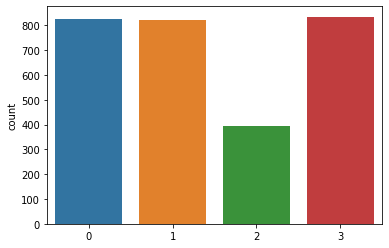

In [ ]:
# Conjunto de entrenamiento
sns.countplot(y_train)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


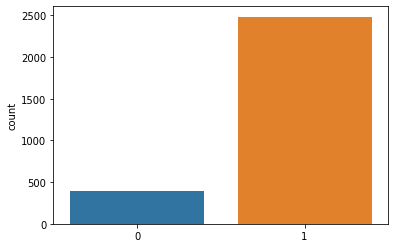

In [ ]:
# Al juntar las clases con cancer
des = y_train.copy()
des = np.where(des < 2, 1, des)
des = np.where(des == 3, 1, des)
des = np.where(des == 2, 0, des)
sns.countplot(des)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


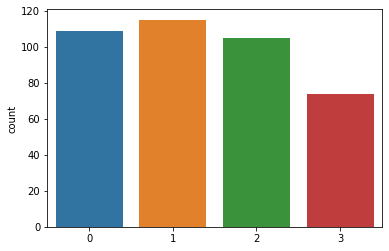

In [ ]:
# Conjunto de test
sns.countplot(y_test)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


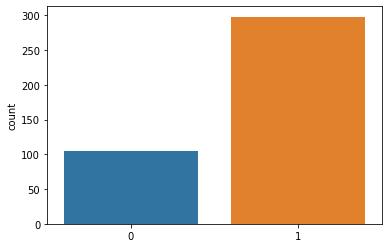

In [ ]:
# Agrupar las instancias con cancer en el conjunto de test 
des = y_test.copy()
des = np.where(des < 2, 1, des)
des = np.where(des == 3, 1, des)
des = np.where(des == 2, 0, des)
sns.countplot(des)

Recortamos las imágenes para ampliar eliminar los margenes negros y después la preprocesamos. Ambas funciones se encuentran implementadas en el fichero utilidades.py

In [ ]:
X_train_crop = recortar_imagen(X_train)
X_test_crop  = recortar_imagen(X_test)

X_train = preprocess_imgs(X_train_crop, IMG_SIZE)
test_set     = preprocess_imgs(X_test_crop, IMG_SIZE)

/content/drive/.shortcut-targets-by-id/1sY20LclC8q7CIMpnOFT3SfYm3hMOB994/Proyecto/utilidades.py:148: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(set_new)


Si queremos hacer __AUMENTO DE DATOS:__

Si ya dispone de un directorio con las imágenes aumentadas entonces NO EJECUTAR LA CELDA. En caso contrario, cree una estructura de directorios de la siguiente manera au_BinaryClasification/no_tumor_au/ y ejecute la celda. 

__Nota:__ Es importante que tenga en cuenta que si ejecuta esta función se escribe en disco.  

__Nota 2:__ La primera vez que se ejecte la celda dará un fallo. La siguiente vez que se ejecute lo hará de manera correcta. Se desconocen las causas del suceso. 

In [ ]:
if aumento == True:
  # Calcuflamos los indices de los ejemplos sin tumor
  result = np.where(y_train==2)[0] # Nos devuelve una lista comprendia entre 1648 y 2042

  # Seleccionamos los ejemplos sin tumor
  no_tumor_labels = y_train[1648:2043]
  no_tumor_training = X_train[1648:2043]  

  # Declaramos el aumento
  no_tumor_datagen = ImageDataGenerator(
          horizontal_flip    = True,
          vertical_flip      = True,
          #brightness_range   = [0.1,1.5],
          rotation_range      = 30,
          #width_shift_range  = 0.05,
          #height_shift_range = 0.05,
          #reescale           = 1/255,
          #shear_range        = 0.05,
          )

  # Convertimos a array
  no_tumor_training =  np.asarray(no_tumor_training,dtype='object')
  no_tumor_labels =  np.asarray(no_tumor_labels,dtype='object')

  # Entrenamos el aumento
  no_tumor_datagen.fit(no_tumor_training)

  # Escribimos en el directorio
  i = 0
  for batch in no_tumor_datagen.flow(no_tumor_training, batch_size = 1 ,save_to_dir='au_BinaryClasification/no_tumor_au/',save_format='jpg',save_prefix='aug_img'):
    i=i+1
    if i >= 505:
      break



La siguiente celda lee las imágenes obtenidas gracias a la ejecucion de la celda anterior y las almacena. Dichas imágenes corresponden al oversampling de la clase no_tumor. Posteriormente se integran en los vectores con todas las imágenes. Si disponemos de los __binarios__ entonces NO EJECUTAR DICHA CELDA, en caso contrario, cree un directorio llamado _au_BinaryClasification_ y meta dentro al directorio _aumented_prueba_ con las imágenes aumentadas. 

In [ ]:
if aumento == True:
  # Cargamos las imagenes aumentadas
  X_no_tumor_au, no_tumor_au_label,dic = carga_datos_openCV('au_BinaryClasification/')  

  # Cambio la etiqueta a la número 2 que corresponde con no_tumor
  no_tumor_au_label[:] = 2

  X_train = np.concatenate((X_train,X_no_tumor_au),axis=0)
  y_train = np.concatenate((y_train,no_tumor_au_label),axis=0)

  # Volvemos a normalizar. Las imágenes normalizadas no se verán afectadas pero las que no lo estén procedentes del aumento sí. 
  X_train = preprocess_imgs(X_train, IMG_SIZE)

100%|██████████| 2/2 [00:14<00:00,  7.06s/it]


1010 imágenes cargadas de la ruta au_BinaryClasification/.


Continuamos con el preprocesado  
Binarizamos las clases: 
- Clase 0: Pacientes sin cáncer
- Clase 1: Pacientes con cáncer

In [ ]:
y_train = np.where(y_train < 2, 1, y_train)
y_train = np.where(y_train == 3, 1, y_train)
y_train = np.where(y_train == 2, 0, y_train)

y_test = np.where(y_test < 2, 1, y_test)
y_test = np.where(y_test == 3, 1, y_test)
y_test = np.where(y_test == 2, 0, y_test)


print ("Entrenamiento-------------")
print(">Cáncer: ",    np.count_nonzero(y_train == 1))
print(">No cáncer: ", np.count_nonzero(y_train == 0))

print("\nTest----------")
print(">Cáncer: ",np.count_nonzero(y_test == 1))
print(">No cáncer: ", np.count_nonzero(y_test == 0))



Visualizamos ahora el número de instancias de cada clase

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


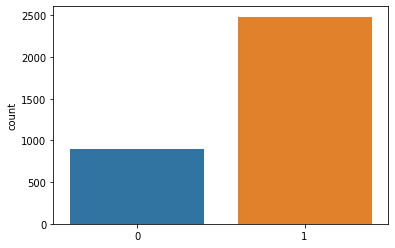

In [ ]:
sns.countplot(y_train)

Vectorizamos las clases

In [ ]:
y_train    = to_categorical(y_train,2)
y_test     = to_categorical(y_test,2)

Barajamos el conjunto de datos para no tener las clases contiguas

In [ ]:
# Declaramos la semilla
seed(123456)

# Guardamos índices
ind_train = list(range(len(X_train)))
ind_test = list(range(len(test_set)))
# Desordenamos
shuffle(ind_train)
shuffle(ind_test)
# Construimos en base a los índices
X_train            = X_train[ind_train]
y_train            = y_train[ind_train]

test_set           = test_set[ind_test]
y_test             = y_test[ind_test]

In [ ]:
y_train.shape

(3383, 2)

Guardamos los binarios para evitar realizar los pasos anteriores cada vez que el kernel se reseté.

__Nota:__ Es importante que sepa que si ejecuta la siguiente celda se escribe en disco.

In [ ]:
directorio = 'Binarios/CB/'
if aumento == True:
  np.save(directorio + 'train_images_aug.npy', X_train)
  np.save(directorio + 'train_labels_aug.npy', y_train)
  np.save(directorio + 'test_images_aug.npy', test_set)
  np.save(directorio + 'test_labels_aug.npy', y_test)
else:
  np.save(directorio + 'train_images.npy', X_train)
  np.save(directorio + 'train_labels.npy', y_train)
  np.save(directorio + 'test_images.npy', test_set)
  np.save(directorio + 'test_labels.npy', y_test)

In [ ]:
training_labels.shape

(2878, 2)

# Funciones Auxiliares

Declaramos las métricas

In [ ]:
# Predicciones positivas correctas entre el numero total de predicciones positivas
def precision(fp,fn,tp,tn):
  return (tp)/(tp+fp)

# TruePositiveRatio o recall: Predicciones positivas correctas entre el numero total de positivos
def recall(fp,fn,tp,tn):
  return (tp)/(tp+fn)

def F1score(recall,precision):
  return 2*(precision*recall)/(precision+recall)

def Gmean(recall,precision):
  return np.sqrt(recall*precision)

# Predicciones negativas incorrectas entre el numero total de positivas
def FalseNegativeRatio(fp,fn,tp,tn):
  return (fn)/(tp+fn)

# Predicciones positivas incorrectas entre el número total de negativas
def FalsePositiveRatio(fp,fn,tp,tn):
  return (fp)/(tn+fp)

# Predicciones neggativas correctas entre el número total de negativos
def TrueNegativeRatio(fp,fn,tp,tn):
  return (tn)/(tn+fp)

# Calcular las métricas a la vez 
def calculate_metrics(fp,fn,tp,tn):

  prec      = precision(fp,fn,tp,tn)
  rec       = recall(fp,fn,tp,tn)
  f1        = F1score(rec,prec)
  gmean     = Gmean(rec,prec)
  FNR       = FalseNegativeRatio(fp,fn,tp,tn)
  FPR       = FalsePositiveRatio(fp,fn,tp,tn)
  TNR       = TrueNegativeRatio(fp,fn,tp,tn)

  return prec ,rec,f1,gmean,FNR,FPR,TNR


def import_metric_pandas(model_name,loss,accuracy,auc,fp,fn,tp,tn):
  '''
  Importamos las métricas a un dataFrame de pandas
  - model_name: nombre del modelo -- string
  '''

  # Metemos estas tres métricas pasadas por argumento
  datos = [loss,accuracy,auc]
  
  # Calculamos el resto
  metricas = calculate_metrics(fp,fn,tp,tn)

  # Las metemos en nuestro vector con todas las métricas
  for dato in metricas :
    datos.append(dato)

  # Convertimos de lista a numpy.array
  datos = np.asarray(datos)

  # Nombramos filas y columnas
  columnas = [model_name] 
  filas = ['loss','accuracy','auc','precision','recall','F1-score','Gmean','FNR','FPR','TNR']

  # Creamos el datafframe
  df = pd.DataFrame(datos, columns=columnas, index=filas)

  return df

Declaramos ahora la función de hold-one-out

In [ ]:
def holdout(model, x_train,y_train,verbose=0, model_name = 'Default', show=False):
  
  # Declaramos early stopping, métricas y función de pérdida
  callback=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=early, restore_best_weights=True)]
  metricas = ['accuracy',metrics.AUC(),metrics.FalsePositives(),metrics.FalseNegatives(),metrics.TruePositives(),metrics.TrueNegatives()]
  loss_function = keras.losses.binary_crossentropy

  # Partición entrenamiento-test
  Xtrain, Xtest, Ytrain, Ytest = train_test_split(x_train, y_train, test_size=0.2)
  # Partición entrenamiento-validacion
  Xtrain, Xvalid, Ytrain, Yvalid = train_test_split(Xtrain, Ytrain, test_size=0.1)

  # Compilacion del modelo: especificamos la métrica Accuracy, la función de perdida a entropia cruzada y el optimizador
  model.compile(loss=loss_function, optimizer=opt, metrics = metricas)

  # Guardamos los pesos
  weights=model.get_weights()


  history = model.fit(x = Xtrain, 
                      y = Ytrain, 
                      batch_size= batch_size,
                      validation_data = (Xvalid, Yvalid), 
                      epochs=epochs, 
                      verbose = verbose,
                      callbacks = callback)
    
  scores = model.evaluate( x = Xtest, y = Ytest, verbose=verbose)



  # Guardamos métricas
  loss = scores[0]
  accuracy = scores[1]
  auc = scores[2]
  fp = scores[3]
  fn = scores[4]
  tp = scores[5]
  tn = scores[6]

  # Reestablecemos los pesos antes del siguiente entrenamiento
  model.set_weights(weights)

  # Guardamos los datos en un dataframe
  df = import_metric_pandas(model_name,loss,accuracy,auc,fp,fn,tp,tn)


  # Visualización
  if show:
    mostrarEvolucion(history)


  print('Numero de epocas realizadas: ', len(history.history['loss']))

  print('------------------------------------------------------------------------')
  print('Resultados obtenidos:')
  print(f'> Loss function: {scores[0]}')
  print(f'> Accuracy: {scores[1]}')
  print(f'> AUC: {scores[2]}')
  print(f'> FP: {scores[3]}')
  print(f'> FN: {scores[4]}')
  print(f'> TP: {scores[5]}')
  print(f'> TN: {scores[6]}')

  return df

Declaramos la función de validación cruazada

In [ ]:
def validacionCruzada(model, x_train,y_train,num_folds,model_name='Default',verbose=0, show=False):
  '''
  Dicha función es usada en el proceso de validación experimental. 
  Recibe como parámetro el modelo, los datos de entrenamiento y el número de folds.
  '''
  # Instanciamos Earlingstopping 
  callback=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=early, restore_best_weights=True)]
  metricas = ['accuracy',metrics.AUC(),metrics.FalsePositives(),metrics.FalseNegatives(),metrics.TruePositives(),metrics.TrueNegatives()]
  loss_function = keras.losses.binary_crossentropy


  # Inicializamos stratified-cross-validation
  skf = StratifiedKFold(n_splits = num_folds, shuffle = False) 


  # Compilacion del modelo: especificamos la métrica Accuracy, la función de perdida a entropia cruzada y el optimizador
  model.compile(loss=loss_function, optimizer=opt, metrics = metricas)

  # Guardamos los pesos
  weights=model.get_weights()

  # Vectores que guardan el valor de sus respectivas métricas en cada fold
  vloss = []
  vacc  = []
  vauc  = []
  vfp   = []
  vfn   = []
  vtp   = []
  vtn   = []


  foldNum=1

  # Para cada fold
  for train_index, test_index in skf.split(x_train,y_train.argmax(1)):
    print(f'Entrenando el fold {foldNum} ...')

    # Calculo los conjuntos de entrenamiento y test
    X_train_cross, X_test_cross = x_train[train_index], x_train[test_index]
    Y_train_cross, Y_test_cross = y_train[train_index], y_train[test_index]

    # Del conjunto de entrenamiento, tomamos un 10% para validación
    fold_x_train, fold_x_valid, fold_y_train, fold_y_valid = train_test_split(X_train_cross, Y_train_cross, test_size=0.1)
    


    # Entrenamiento: se especifican los conjuntos de train,validación,numero de epocas, EarlyStopping definido anteriormente
    history = model.fit(x = fold_x_train, 
                        y = fold_y_train, 
                        batch_size= batch_size,
                        validation_data = (fold_x_valid, fold_y_valid), 
                        epochs=epochs, 
                        verbose = verbose,
                        callbacks = callback)
      
    # Evaluamos con los datos de test
    scores = model.evaluate(x=X_test_cross, y=Y_test_cross, verbose=verbose)

    # Añadimos métricas
    vloss.append(scores[0])
    vacc.append(scores[1])
    vauc.append(scores[2])
    vfp.append(scores[3])
    vfn.append(scores[4])
    vtp.append(scores[5])
    vtn.append(scores[6])
    foldNum+=1

    # Reestablecemos los pesos antes del siguiente entrenamiento
    model.set_weights(weights)

    # Visualización
    if show:
      mostrarEvolucion(history)

    print(f'Fold {foldNum} - Numero de epocas realizadas: ', len(history.history['loss']))

  # Convertimos a numpy arrays y hacemos la media
  vloss = np.asarray(vloss)
  vacc  = np.asarray(vacc)
  vauc  = np.asarray(vauc)
  vfp   = np.asarray(vfp)
  vfn   = np.asarray(vfn)
  vtp   = np.asarray(vtp)
  vtn   = np.asarray(vtn)

  vloss = vloss.mean()
  vacc  = vacc.mean()
  vauc  = vauc.mean()
  vfp   = vfp.mean()
  vfn   = vfn.mean()
  vtp   = vtp.mean()
  vtn   = vtn.mean()  

  # Creamos el dataFrame 
  df = import_metric_pandas(model_name,vloss,vacc,vauc,vfp,vfn,vtp,vtn)

  # Mostramos resultados
  print('------------------------------------------------------------------------')
  print('Resultados obtenidos:')
  print(f'> Loss function: {vloss}')
  print(f'> Accuracy: {vacc}')
  print(f'> AUC: {vauc}')
  print(f'> FP: {vfp}')
  print(f'> FN: {vfn}')
  print(f'> TP: {vtp}')
  print(f'> TN: {vtn}')

  return df

Declaramos la función que usaremos para evaluar en el conjunto de test

In [ ]:
def fit_evaluate(model,model_name,x_train,y_train,x_test,y_test,verbose=0,show = False):
  """
  Función que entrena al modelo pasado como parámetro y lo evalua.
  Función válida tanto para hacer validación como para evaluar en test.
  """

  # Declaramos early stopping, métricas y función de pérdida
  metricas = ['accuracy',metrics.AUC(),metrics.FalsePositives(),metrics.FalseNegatives(),metrics.TruePositives(),metrics.TrueNegatives()]
  loss_function = keras.losses.binary_crossentropy
  callback=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=early, restore_best_weights=True)]

  # Guardamos los pesos
  weights=model.get_weights()

  # Hacemos una partición para validación 
  x_training, x_valid, y_training, y_valid = train_test_split(x_train, y_train, test_size=0.1)

  # Compilacion del modelo: especificamos la métrica Accuracy, la función de perdida a entropia cruzada y el optimizador
  model.compile(loss=loss_function, optimizer=opt, metrics = metricas)

  # Entrenamos al modelo
  history = model.fit(x = x_training, 
                      y = y_training, 
                      batch_size= batch_size,
                      validation_data = (x_valid, y_valid), 
                      epochs=epochs, 
                      verbose = verbose,
                      callbacks = callback)
  
  # Evaluamos el modelo
  scores = model.evaluate(x = x_test, y = y_test, verbose=verbose)



  # Reestablecemos los pesos antes del siguiente entrenamiento
  model.set_weights(weights)

  # Guardamos métricas
  loss = scores[0]
  accuracy = scores[1]
  auc = scores[2]
  fp = scores[3]
  fn = scores[4]
  tp = scores[5]
  tn = scores[6]


  # Guardamos los datos en un dataframe
  df = import_metric_pandas(model_name,loss,accuracy,auc,fp,fn,tp,tn)

  # Visualización
  if show == True:
    mostrarEvolucion(history)

  print('Numero de epocas realizadas: ', len(history.history['loss']))

  print('------------------------------------------------------------------------')
  print('Resultados obtenidos:')
  print(f'> Loss function: {scores[0]}')
  print(f'> Accuracy: {scores[1]}')
  print(f'> AUC: {scores[2]}')
  print(f'> FP: {scores[3]}')
  print(f'> FN: {scores[4]}')
  print(f'> TP: {scores[5]}')
  print(f'> TN: {scores[6]}')

  return df


# **Modelos**

Los conjuntos tienen los siguientes nombres:
- __training_set__: Conjunto de entrenamiento
- __training_labels__: Etiquetas del conjunto de entrenamiento
- __test_set__: Conjunto de test
- __test_labels__: Etiquetas del conjunto de test

In [ ]:
training_labels.shape

(2878, 2)

In [ ]:
batch_size = 32
epochs = 40
early = 7
opt = tf.keras.optimizers.Adam(learning_rate = 1e-3)

## Modelo 1: 

Inicialmente partimos de la arquitectura de la red DenseNet121 quitando la capa totalmenteconectada  de  la  parte  superior. A continuación, añadimos una capa densa con dos neuronas. 


In [ ]:
def modelo1():

  #Definimos nuestro modelo 
  #-include_top a false porque no vamos a incluir la capa totalmente conectada en la parte superior de la red
  #   Hemos quitado la ultima capa para usar la red como extractor de características !!
  #-weight='imageNet', se entrena la red con ImageNet
  #-pooling='avg' AveragePooling
  #-Como include_top esta a false se debe especificar  input_shape
  model = DenseNet121(weights='imagenet', include_top=False, pooling='avg',input_shape=(224,224,3))

  #Marcamos los pesos como no entrenables para que solo afecte a los pesos de las capas FC
  model.trainable=False

  #Probamos la red DenseNet preentrenada con ImageNet añadiendole una capa dense de 2 neuronas
  modelSimple= (layers.Dense(2, activation = 'softmax'))(model.output)
  modelSimple=Model(inputs = model.inputs, outputs = modelSimple)

  return modelSimple

29097984/29084464 [==============================] - 0s 0us/step
Entrenando el fold 1 ...
Epoch 1/40
54/54 [==============================] - 28s 205ms/step - loss: 0.3324 - accuracy: 0.8778 - auc: 0.9354 - false_positives: 211.0000 - false_negatives: 211.0000 - true_positives: 1515.0000 - true_negatives: 1515.0000 - val_loss: 0.2173 - val_accuracy: 0.9115 - val_auc: 0.9803 - val_false_positives: 17.0000 - val_false_negatives: 17.0000 - val_true_positives: 175.0000 - val_true_negatives: 175.0000
Epoch 2/40
54/54 [==============================] - 6s 115ms/step - loss: 0.2007 - accuracy: 0.9195 - auc: 0.9809 - false_positives: 139.0000 - false_negatives: 139.0000 - true_positives: 1587.0000 - true_negatives: 1587.0000 - val_loss: 0.1583 - val_accuracy: 0.9427 - val_auc: 0.9851 - val_false_positives: 11.0000 - val_false_negatives: 11.0000 - val_true_positives: 181.0000 - val_true_negatives: 181.0000
Epoch 3/40
54/54 [==============================] - 6s 115ms/step - loss: 0.1574 - accura

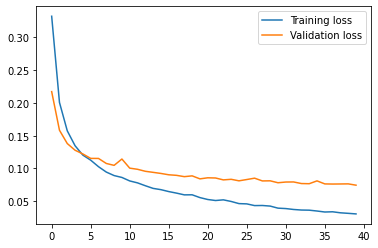

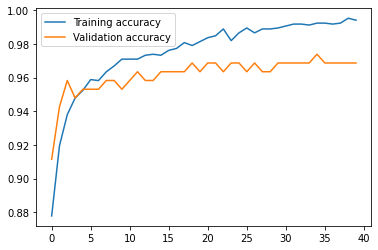

Fold 2 - Numero de epocas realizadas:  40
Entrenando el fold 2 ...
Epoch 1/40
54/54 [==============================] - 8s 150ms/step - loss: 0.2741 - accuracy: 0.9045 - auc: 0.9514 - false_positives: 165.0000 - false_negatives: 165.0000 - true_positives: 1562.0000 - true_negatives: 1562.0000 - val_loss: 0.1938 - val_accuracy: 0.9219 - val_auc: 0.9829 - val_false_positives: 15.0000 - val_false_negatives: 15.0000 - val_true_positives: 177.0000 - val_true_negatives: 177.0000
Epoch 2/40
54/54 [==============================] - 6s 118ms/step - loss: 0.1340 - accuracy: 0.9473 - auc: 0.9884 - false_positives: 91.0000 - false_negatives: 91.0000 - true_positives: 1636.0000 - true_negatives: 1636.0000 - val_loss: 0.1569 - val_accuracy: 0.9167 - val_auc: 0.9881 - val_false_positives: 16.0000 - val_false_negatives: 16.0000 - val_true_positives: 176.0000 - val_true_negatives: 176.0000
Epoch 3/40
54/54 [==============================] - 6s 119ms/step - loss: 0.1101 - accuracy: 0.9618 - auc: 0.9925 -

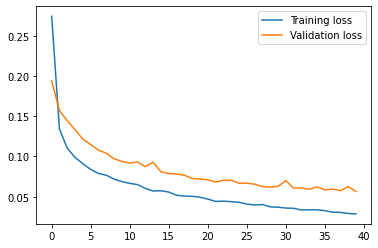

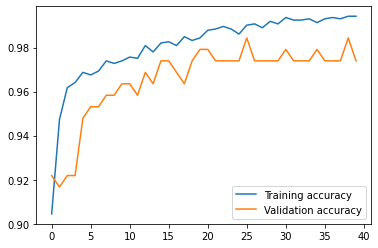

Fold 3 - Numero de epocas realizadas:  40
Entrenando el fold 3 ...
Epoch 1/40
54/54 [==============================] - 7s 126ms/step - loss: 0.2377 - accuracy: 0.9137 - auc: 0.9695 - false_positives: 149.0000 - false_negatives: 149.0000 - true_positives: 1578.0000 - true_negatives: 1578.0000 - val_loss: 0.1243 - val_accuracy: 0.9427 - val_auc: 0.9930 - val_false_positives: 11.0000 - val_false_negatives: 11.0000 - val_true_positives: 181.0000 - val_true_negatives: 181.0000
Epoch 2/40
54/54 [==============================] - 6s 118ms/step - loss: 0.1190 - accuracy: 0.9583 - auc: 0.9894 - false_positives: 72.0000 - false_negatives: 72.0000 - true_positives: 1655.0000 - true_negatives: 1655.0000 - val_loss: 0.1001 - val_accuracy: 0.9531 - val_auc: 0.9909 - val_false_positives: 9.0000 - val_false_negatives: 9.0000 - val_true_positives: 183.0000 - val_true_negatives: 183.0000
Epoch 3/40
54/54 [==============================] - 6s 119ms/step - loss: 0.1012 - accuracy: 0.9647 - auc: 0.9915 - f

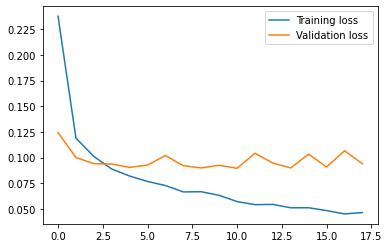

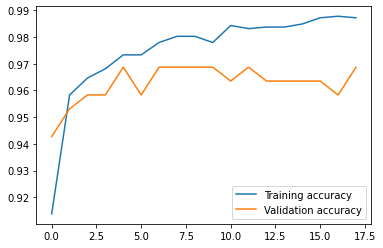

Fold 4 - Numero de epocas realizadas:  18
------------------------------------------------------------------------
Resultados obtenidos:
> Loss function: 0.08251236875851949
> Accuracy: 0.9680327375729879
> AUC: 0.9928891062736511
> FP: 30.666666666666668
> FN: 30.666666666666668
> TP: 928.6666666666666
> TN: 928.6666666666666


In [ ]:
# Ejecución hecha sin oversampling
modelSimple = modelo1()
df_modelo_simple=validacionCruzada(model = modelSimple, x_train = training_set, y_train = training_labels, num_folds = 3, model_name='Modelo 1',verbose=1, show=True)

In [ ]:
# Guardamos en disco los resultados
#df_modelo_simple
#df_modelo_simple.to_csv('modeloSimpleNoAumento.csv')

Entrenando el fold 1 ...
Epoch 1/40
64/64 [==============================] - 37s 327ms/step - loss: 0.3615 - accuracy: 0.8684 - auc: 0.9278 - false_positives: 267.0000 - false_negatives: 267.0000 - true_positives: 1762.0000 - true_negatives: 1762.0000 - val_loss: 0.2922 - val_accuracy: 0.8894 - val_auc: 0.9581 - val_false_positives: 25.0000 - val_false_negatives: 25.0000 - val_true_positives: 201.0000 - val_true_negatives: 201.0000
Epoch 2/40
64/64 [==============================] - 16s 245ms/step - loss: 0.2575 - accuracy: 0.9014 - auc: 0.9656 - false_positives: 200.0000 - false_negatives: 200.0000 - true_positives: 1829.0000 - true_negatives: 1829.0000 - val_loss: 0.2698 - val_accuracy: 0.8894 - val_auc: 0.9586 - val_false_positives: 25.0000 - val_false_negatives: 25.0000 - val_true_positives: 201.0000 - val_true_negatives: 201.0000
Epoch 3/40
64/64 [==============================] - 16s 246ms/step - loss: 0.2336 - accuracy: 0.9123 - auc: 0.9725 - false_positives: 178.0000 - false_ne

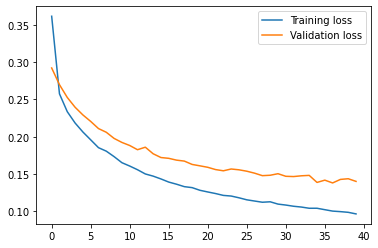

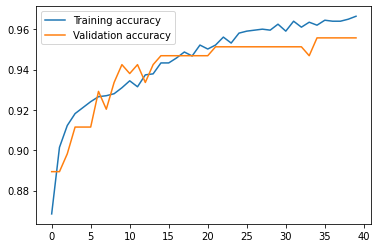

Fold 2 - Numero de epocas realizadas:  40
Entrenando el fold 2 ...
Epoch 1/40
64/64 [==============================] - 16s 253ms/step - loss: 0.3052 - accuracy: 0.8817 - auc: 0.9462 - false_positives: 240.0000 - false_negatives: 240.0000 - true_positives: 1789.0000 - true_negatives: 1789.0000 - val_loss: 0.2287 - val_accuracy: 0.9159 - val_auc: 0.9726 - val_false_positives: 19.0000 - val_false_negatives: 19.0000 - val_true_positives: 207.0000 - val_true_negatives: 207.0000
Epoch 2/40
64/64 [==============================] - 16s 248ms/step - loss: 0.2267 - accuracy: 0.9133 - auc: 0.9731 - false_positives: 176.0000 - false_negatives: 176.0000 - true_positives: 1853.0000 - true_negatives: 1853.0000 - val_loss: 0.2070 - val_accuracy: 0.9204 - val_auc: 0.9756 - val_false_positives: 18.0000 - val_false_negatives: 18.0000 - val_true_positives: 208.0000 - val_true_negatives: 208.0000
Epoch 3/40
64/64 [==============================] - 16s 248ms/step - loss: 0.2074 - accuracy: 0.9172 - auc: 0.9

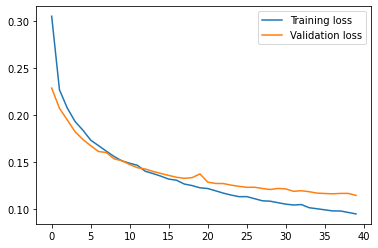

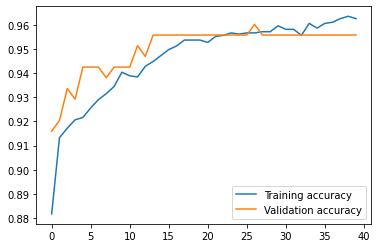

Fold 3 - Numero de epocas realizadas:  40
Entrenando el fold 3 ...
Epoch 1/40
64/64 [==============================] - 18s 274ms/step - loss: 0.3017 - accuracy: 0.8842 - auc: 0.9477 - false_positives: 235.0000 - false_negatives: 235.0000 - true_positives: 1795.0000 - true_negatives: 1795.0000 - val_loss: 0.2471 - val_accuracy: 0.9071 - val_auc: 0.9624 - val_false_positives: 21.0000 - val_false_negatives: 21.0000 - val_true_positives: 205.0000 - val_true_negatives: 205.0000
Epoch 2/40
64/64 [==============================] - 17s 266ms/step - loss: 0.2242 - accuracy: 0.9138 - auc: 0.9748 - false_positives: 175.0000 - false_negatives: 175.0000 - true_positives: 1855.0000 - true_negatives: 1855.0000 - val_loss: 0.2355 - val_accuracy: 0.9027 - val_auc: 0.9658 - val_false_positives: 22.0000 - val_false_negatives: 22.0000 - val_true_positives: 204.0000 - val_true_negatives: 204.0000
Epoch 3/40
64/64 [==============================] - 16s 249ms/step - loss: 0.2088 - accuracy: 0.9177 - auc: 0.9

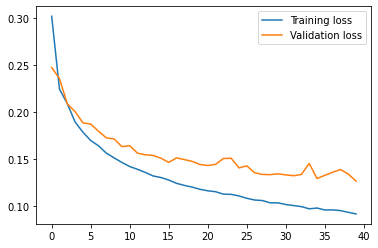

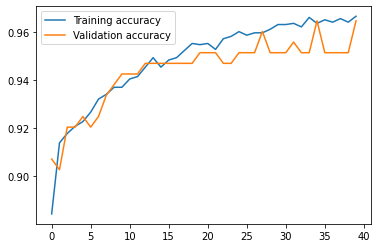

Fold 4 - Numero de epocas realizadas:  40
------------------------------------------------------------------------
Resultados obtenidos:
> Loss function: 0.12127268562714259
> Accuracy: 0.9559572140375773
> AUC: 0.9880881309509277
> FP: 49.666666666666664
> FN: 49.666666666666664
> TP: 1078.0
> TN: 1078.0


In [ ]:
# Ejecución con oversampling
df_modelo_simple=modelo1()

In [ ]:
# Guardamos en disco los resultados
#df_modelo_simple
#df_modelo_simple.to_csv('modeloSimpleAumento.csv')

## Modelo 2: 
Al igual que antes partimos de la arquitectura de la red DenseNet121 quitando la capa totalmente conectada de la parte superior pero vamos a  añadir varias capas densas.

https://link.springer.com/chapter/10.1007/978-981-16-2008-9_1

In [ ]:
def modelo2():
  model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224,224,3))
 
  #Marcamos los pesos como no entrenables para que solo afecte a los pesos de las capas FC
  model.trainable=False
  
  #Probamos la red DenseNet preentrenada con ImageNet añadiendole varias capas densas
  modelSimple= (layers.Flatten())(model.output)
  modelSimple= (layers.Dense(1024, activation = 'relu'))(modelSimple)
  modelSimple= (layers.BatchNormalization())(modelSimple)
  modelSimple= (layers.Dropout(0.4))(modelSimple) 
  modelSimple= (layers.Dense(512, activation = 'relu'))(modelSimple)
  modelSimple= (layers.BatchNormalization())(modelSimple)
  modelSimple= (layers.Dropout(0.5))(modelSimple)
  modelSimple= (layers.Dense(2, activation = 'softmax'))(modelSimple)

  modelSimple=Model(inputs = model.inputs, outputs = modelSimple)

  return modelSimple

Entrenando el fold 1 ...
Epoch 1/40
54/54 [==============================] - 37s 377ms/step - loss: 0.5041 - accuracy: 0.8389 - auc: 0.9015 - false_positives: 278.0000 - false_negatives: 278.0000 - true_positives: 1448.0000 - true_negatives: 1448.0000 - val_loss: 0.1872 - val_accuracy: 0.9531 - val_auc: 0.9823 - val_false_positives: 9.0000 - val_false_negatives: 9.0000 - val_true_positives: 183.0000 - val_true_negatives: 183.0000
Epoch 2/40
54/54 [==============================] - 15s 281ms/step - loss: 0.2031 - accuracy: 0.9368 - auc: 0.9797 - false_positives: 109.0000 - false_negatives: 109.0000 - true_positives: 1617.0000 - true_negatives: 1617.0000 - val_loss: 0.1021 - val_accuracy: 0.9688 - val_auc: 0.9922 - val_false_positives: 6.0000 - val_false_negatives: 6.0000 - val_true_positives: 186.0000 - val_true_negatives: 186.0000
Epoch 3/40
54/54 [==============================] - 15s 275ms/step - loss: 0.1084 - accuracy: 0.9762 - auc: 0.9911 - false_positives: 41.0000 - false_negativ

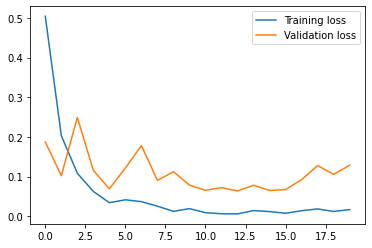

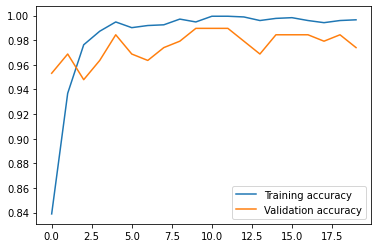

Fold 2 - Numero de epocas realizadas:  20
Entrenando el fold 2 ...
Epoch 1/40
54/54 [==============================] - 18s 329ms/step - loss: 0.3882 - accuracy: 0.8697 - auc: 0.9299 - false_positives: 225.0000 - false_negatives: 225.0000 - true_positives: 1502.0000 - true_negatives: 1502.0000 - val_loss: 0.2750 - val_accuracy: 0.9427 - val_auc: 0.9522 - val_false_positives: 11.0000 - val_false_negatives: 11.0000 - val_true_positives: 181.0000 - val_true_negatives: 181.0000
Epoch 2/40
54/54 [==============================] - 15s 285ms/step - loss: 0.1301 - accuracy: 0.9629 - auc: 0.9885 - false_positives: 64.0000 - false_negatives: 64.0000 - true_positives: 1663.0000 - true_negatives: 1663.0000 - val_loss: 0.1075 - val_accuracy: 0.9635 - val_auc: 0.9829 - val_false_positives: 7.0000 - val_false_negatives: 7.0000 - val_true_positives: 185.0000 - val_true_negatives: 185.0000
Epoch 3/40
54/54 [==============================] - 15s 283ms/step - loss: 0.0628 - accuracy: 0.9855 - auc: 0.9951 

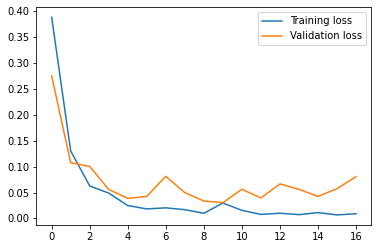

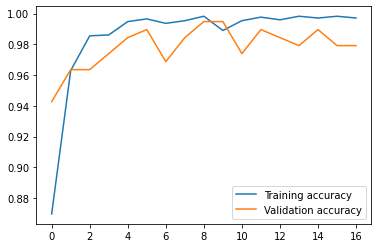

Fold 3 - Numero de epocas realizadas:  17
Entrenando el fold 3 ...
Epoch 1/40
54/54 [==============================] - 16s 298ms/step - loss: 0.3721 - accuracy: 0.8964 - auc: 0.9442 - false_positives: 179.0000 - false_negatives: 179.0000 - true_positives: 1548.0000 - true_negatives: 1548.0000 - val_loss: 6.1798 - val_accuracy: 0.1510 - val_auc: 0.1461 - val_false_positives: 163.0000 - val_false_negatives: 163.0000 - val_true_positives: 29.0000 - val_true_negatives: 29.0000
Epoch 2/40
54/54 [==============================] - 15s 284ms/step - loss: 0.1296 - accuracy: 0.9612 - auc: 0.9860 - false_positives: 67.0000 - false_negatives: 67.0000 - true_positives: 1660.0000 - true_negatives: 1660.0000 - val_loss: 0.1724 - val_accuracy: 0.9792 - val_auc: 0.9828 - val_false_positives: 4.0000 - val_false_negatives: 4.0000 - val_true_positives: 188.0000 - val_true_negatives: 188.0000
Epoch 3/40
54/54 [==============================] - 15s 283ms/step - loss: 0.0715 - accuracy: 0.9780 - auc: 0.9957 

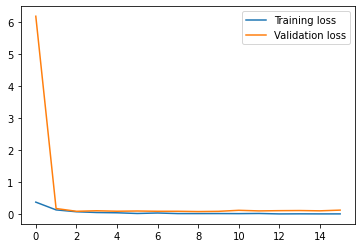

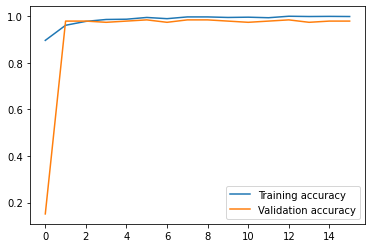

Fold 4 - Numero de epocas realizadas:  16
------------------------------------------------------------------------
Resultados obtenidos:
> Loss function: 0.10269476970036824
> Accuracy: 0.9767198165257772
> AUC: 0.9865362644195557
> FP: 22.333333333333332
> FN: 22.333333333333332
> TP: 937.0
> TN: 937.0


In [ ]:
# Sin oversampling
modelSimple = modelo2()
df_modelo2 = validacionCruzada(model = modelSimple, x_train = training_set, y_train = training_labels, num_folds = 3, model_name='Modelo 2',verbose=1, show=True)

In [ ]:
# Guardamos en disco los resultados
#df_modelo2
#df_modelo2.to_csv('modelo2NoAumento.csv')

Entrenando el fold 1 ...
Epoch 1/40
64/64 [==============================] - 40s 364ms/step - loss: 0.2568 - accuracy: 0.9078 - auc: 0.9612 - false_positives: 187.0000 - false_negatives: 187.0000 - true_positives: 1842.0000 - true_negatives: 1842.0000 - val_loss: 0.1233 - val_accuracy: 0.9558 - val_auc: 0.9802 - val_false_positives: 10.0000 - val_false_negatives: 10.0000 - val_true_positives: 216.0000 - val_true_negatives: 216.0000
Epoch 2/40
64/64 [==============================] - 18s 278ms/step - loss: 0.1454 - accuracy: 0.9497 - auc: 0.9835 - false_positives: 102.0000 - false_negatives: 102.0000 - true_positives: 1927.0000 - true_negatives: 1927.0000 - val_loss: 0.0766 - val_accuracy: 0.9602 - val_auc: 0.9892 - val_false_positives: 9.0000 - val_false_negatives: 9.0000 - val_true_positives: 217.0000 - val_true_negatives: 217.0000
Epoch 3/40
64/64 [==============================] - 17s 273ms/step - loss: 0.1049 - accuracy: 0.9675 - auc: 0.9898 - false_positives: 66.0000 - false_negat

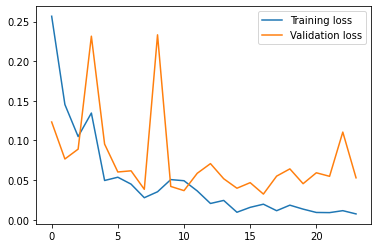

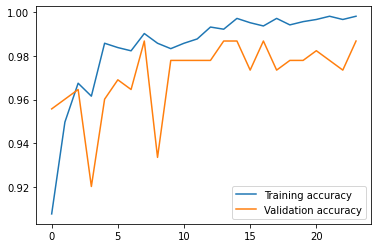

Fold 2 - Numero de epocas realizadas:  24
Entrenando el fold 2 ...
Epoch 1/40
64/64 [==============================] - 18s 288ms/step - loss: 0.2588 - accuracy: 0.9192 - auc: 0.9587 - false_positives: 164.0000 - false_negatives: 164.0000 - true_positives: 1865.0000 - true_negatives: 1865.0000 - val_loss: 0.2080 - val_accuracy: 0.9336 - val_auc: 0.9513 - val_false_positives: 15.0000 - val_false_negatives: 15.0000 - val_true_positives: 211.0000 - val_true_negatives: 211.0000
Epoch 2/40
64/64 [==============================] - 18s 276ms/step - loss: 0.1515 - accuracy: 0.9468 - auc: 0.9822 - false_positives: 108.0000 - false_negatives: 108.0000 - true_positives: 1921.0000 - true_negatives: 1921.0000 - val_loss: 0.1797 - val_accuracy: 0.9425 - val_auc: 0.9646 - val_false_positives: 13.0000 - val_false_negatives: 13.0000 - val_true_positives: 213.0000 - val_true_negatives: 213.0000
Epoch 3/40
64/64 [==============================] - 18s 278ms/step - loss: 0.1095 - accuracy: 0.9655 - auc: 0.9

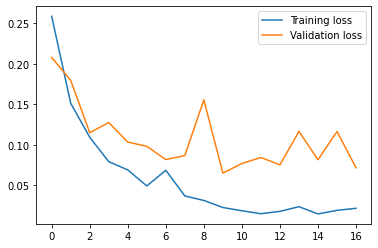

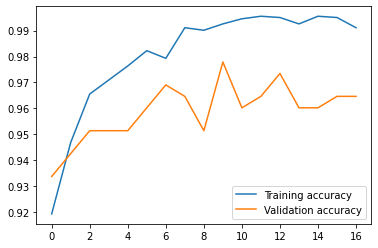

Fold 3 - Numero de epocas realizadas:  17
Entrenando el fold 3 ...
Epoch 1/40
64/64 [==============================] - 20s 311ms/step - loss: 0.2643 - accuracy: 0.9089 - auc: 0.9562 - false_positives: 185.0000 - false_negatives: 185.0000 - true_positives: 1845.0000 - true_negatives: 1845.0000 - val_loss: 0.3087 - val_accuracy: 0.9336 - val_auc: 0.9658 - val_false_positives: 15.0000 - val_false_negatives: 15.0000 - val_true_positives: 211.0000 - val_true_negatives: 211.0000
Epoch 2/40
64/64 [==============================] - 18s 279ms/step - loss: 0.1450 - accuracy: 0.9433 - auc: 0.9858 - false_positives: 115.0000 - false_negatives: 115.0000 - true_positives: 1915.0000 - true_negatives: 1915.0000 - val_loss: 0.1260 - val_accuracy: 0.9602 - val_auc: 0.9801 - val_false_positives: 9.0000 - val_false_negatives: 9.0000 - val_true_positives: 217.0000 - val_true_negatives: 217.0000
Epoch 3/40
64/64 [==============================] - 18s 278ms/step - loss: 0.1058 - accuracy: 0.9601 - auc: 0.988

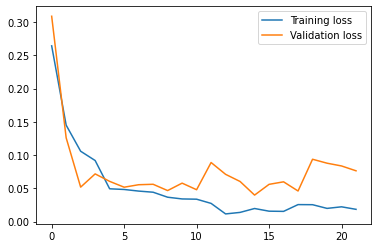

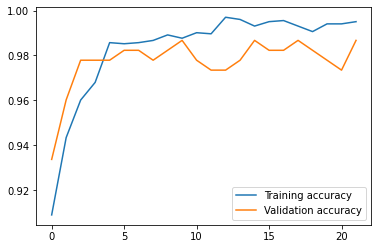

Fold 4 - Numero de epocas realizadas:  22
------------------------------------------------------------------------
Resultados obtenidos:
> Loss function: 0.09419806053241093
> Accuracy: 0.9704402685165405
> AUC: 0.9864266514778137
> FP: 33.333333333333336
> FN: 33.333333333333336
> TP: 1094.3333333333333
> TN: 1094.3333333333333


In [ ]:
# Ejecución con oversampling
df_modelo2 = modelo2()

In [ ]:
# Guardamos en disco los resultados
#df_modelo2
#df_modelo2.to_csv('modelo2Aumento.csv')

## Modelo 3: 
Añadimos un bloque VGG y a continuación una capa Densa junto con capas Dropout y BatchNormalization

https://machinelearningmastery-com.translate.goog/how-to-implement-major-architecture-innovations-for-convolutional-neural-networks/?_x_tr_sl=en&_x_tr_tl=es&_x_tr_hl=es&_x_tr_pto=sc

In [ ]:
# function for creating a vgg block
def vgg_block(layer_in, n_filters, n_conv):
	# Añadimos capas de convolución
	for _ in range(n_conv):
		layer_in = Conv2D(n_filters, (3,3), padding='same', activation='relu')(layer_in)
	# Añadimos capa max pooling
	layer_in = MaxPooling2D((2,2), strides=(2,2))(layer_in)
	return layer_in    
               
def modelo_vgg():
  model = DenseNet121(weights='imagenet', include_top=False,input_shape=(224,224,3))

  #Marcamos los pesos como no entrenables para que solo afecte a los pesos de las capas FC
  model.trainable=False

  #Añadimos el bloque VGG y a continuación la FC
  modelSimple= vgg_block(model.output,64,2)
  modelSimple= (layers.Flatten())(modelSimple)
  modelSimple= (layers.BatchNormalization())(modelSimple)
  modelSimple= (layers.Dropout(0.5))(modelSimple)
  modelSimple= (layers.Dense(2, activation = 'softmax'))(modelSimple)

  modelSimple=Model(inputs = model.inputs, outputs = modelSimple)
  
  return modelSimple

Entrenando el fold 1 ...
Epoch 1/40
54/54 [==============================] - 37s 356ms/step - loss: 0.5019 - accuracy: 0.8053 - auc: 0.8777 - false_positives: 336.0000 - false_negatives: 336.0000 - true_positives: 1390.0000 - true_negatives: 1390.0000 - val_loss: 0.1329 - val_accuracy: 0.9583 - val_auc: 0.9717 - val_false_positives: 8.0000 - val_false_negatives: 8.0000 - val_true_positives: 184.0000 - val_true_negatives: 184.0000
Epoch 2/40
54/54 [==============================] - 16s 293ms/step - loss: 0.1771 - accuracy: 0.9612 - auc: 0.9870 - false_positives: 67.0000 - false_negatives: 67.0000 - true_positives: 1659.0000 - true_negatives: 1659.0000 - val_loss: 0.1348 - val_accuracy: 0.9531 - val_auc: 0.9768 - val_false_positives: 9.0000 - val_false_negatives: 9.0000 - val_true_positives: 183.0000 - val_true_negatives: 183.0000
Epoch 3/40
54/54 [==============================] - 14s 256ms/step - loss: 0.0897 - accuracy: 0.9786 - auc: 0.9970 - false_positives: 37.0000 - false_negatives

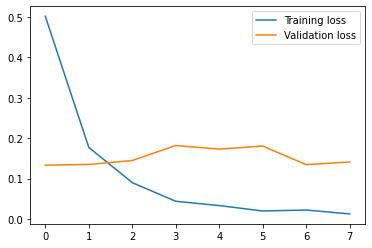

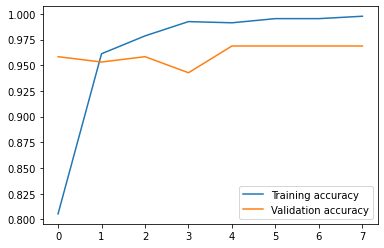

Fold 2 - Numero de epocas realizadas:  8
Entrenando el fold 2 ...
Epoch 1/40
54/54 [==============================] - 16s 301ms/step - loss: 0.4586 - accuracy: 0.8205 - auc: 0.8978 - false_positives: 310.0000 - false_negatives: 310.0000 - true_positives: 1417.0000 - true_negatives: 1417.0000 - val_loss: 0.1779 - val_accuracy: 0.9427 - val_auc: 0.9843 - val_false_positives: 11.0000 - val_false_negatives: 11.0000 - val_true_positives: 181.0000 - val_true_negatives: 181.0000
Epoch 2/40
54/54 [==============================] - 14s 258ms/step - loss: 0.1381 - accuracy: 0.9641 - auc: 0.9901 - false_positives: 62.0000 - false_negatives: 62.0000 - true_positives: 1665.0000 - true_negatives: 1665.0000 - val_loss: 0.4072 - val_accuracy: 0.8542 - val_auc: 0.9098 - val_false_positives: 28.0000 - val_false_negatives: 28.0000 - val_true_positives: 164.0000 - val_true_negatives: 164.0000
Epoch 3/40
54/54 [==============================] - 15s 276ms/step - loss: 0.0798 - accuracy: 0.9739 - auc: 0.9966

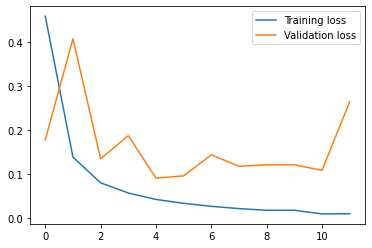

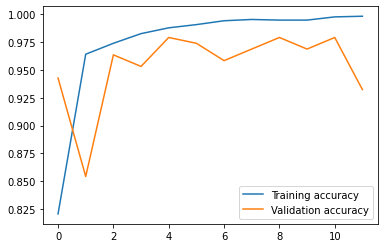

Fold 3 - Numero de epocas realizadas:  12
Entrenando el fold 3 ...
Epoch 1/40
54/54 [==============================] - 15s 276ms/step - loss: 0.3563 - accuracy: 0.8801 - auc: 0.9372 - false_positives: 207.0000 - false_negatives: 207.0000 - true_positives: 1520.0000 - true_negatives: 1520.0000 - val_loss: 0.5932 - val_accuracy: 0.9062 - val_auc: 0.9231 - val_false_positives: 18.0000 - val_false_negatives: 18.0000 - val_true_positives: 174.0000 - val_true_negatives: 174.0000
Epoch 2/40
54/54 [==============================] - 14s 263ms/step - loss: 0.1161 - accuracy: 0.9664 - auc: 0.9909 - false_positives: 58.0000 - false_negatives: 58.0000 - true_positives: 1669.0000 - true_negatives: 1669.0000 - val_loss: 0.2041 - val_accuracy: 0.9583 - val_auc: 0.9708 - val_false_positives: 8.0000 - val_false_negatives: 8.0000 - val_true_positives: 184.0000 - val_true_negatives: 184.0000
Epoch 3/40
54/54 [==============================] - 15s 276ms/step - loss: 0.0812 - accuracy: 0.9728 - auc: 0.9938 

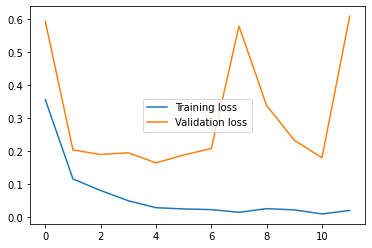

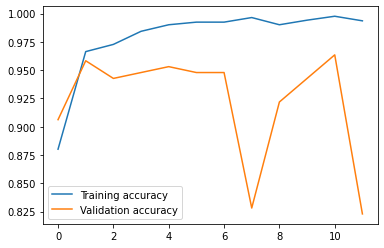

Fold 4 - Numero de epocas realizadas:  12
------------------------------------------------------------------------
Resultados obtenidos:
> Loss function: 0.09166503697633743
> Accuracy: 0.96942271788915
> AUC: 0.9880624612172445
> FP: 29.333333333333332
> FN: 29.333333333333332
> TP: 930.0
> TN: 930.0


In [ ]:
# Sin oversampling
modeloVGG = modelo_vgg()
df_vgg=validacionCruzada(model = modeloVGG, x_train = training_set, y_train = training_labels, num_folds = 3, model_name='ModeloVGG',verbose=1, show=True)

In [ ]:
# Guardamos en disco los resultados
#df_vgg
#df_vgg.to_csv('VGGNoAumento.csv')

Entrenando el fold 1 ...
Epoch 1/40
64/64 [==============================] - 40s 347ms/step - loss: 0.2604 - accuracy: 0.9004 - auc: 0.9605 - false_positives: 202.0000 - false_negatives: 202.0000 - true_positives: 1827.0000 - true_negatives: 1827.0000 - val_loss: 0.3322 - val_accuracy: 0.9159 - val_auc: 0.9383 - val_false_positives: 19.0000 - val_false_negatives: 19.0000 - val_true_positives: 207.0000 - val_true_negatives: 207.0000
Epoch 2/40
64/64 [==============================] - 17s 262ms/step - loss: 0.1642 - accuracy: 0.9404 - auc: 0.9814 - false_positives: 121.0000 - false_negatives: 121.0000 - true_positives: 1908.0000 - true_negatives: 1908.0000 - val_loss: 0.1824 - val_accuracy: 0.9558 - val_auc: 0.9784 - val_false_positives: 10.0000 - val_false_negatives: 10.0000 - val_true_positives: 216.0000 - val_true_negatives: 216.0000
Epoch 3/40
64/64 [==============================] - 17s 263ms/step - loss: 0.1139 - accuracy: 0.9606 - auc: 0.9893 - false_positives: 80.0000 - false_neg

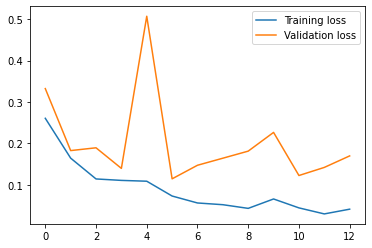

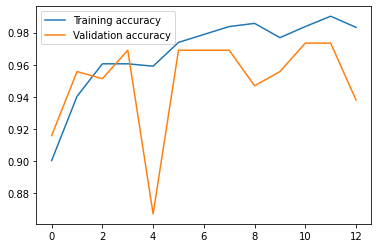

Fold 2 - Numero de epocas realizadas:  13
Entrenando el fold 2 ...
Epoch 1/40
64/64 [==============================] - 17s 273ms/step - loss: 0.2768 - accuracy: 0.9029 - auc: 0.9544 - false_positives: 197.0000 - false_negatives: 197.0000 - true_positives: 1832.0000 - true_negatives: 1832.0000 - val_loss: 0.2190 - val_accuracy: 0.9248 - val_auc: 0.9678 - val_false_positives: 17.0000 - val_false_negatives: 17.0000 - val_true_positives: 209.0000 - val_true_negatives: 209.0000
Epoch 2/40
64/64 [==============================] - 17s 264ms/step - loss: 0.1638 - accuracy: 0.9384 - auc: 0.9810 - false_positives: 125.0000 - false_negatives: 125.0000 - true_positives: 1904.0000 - true_negatives: 1904.0000 - val_loss: 0.1139 - val_accuracy: 0.9513 - val_auc: 0.9903 - val_false_positives: 11.0000 - val_false_negatives: 11.0000 - val_true_positives: 215.0000 - val_true_negatives: 215.0000
Epoch 3/40
64/64 [==============================] - 17s 262ms/step - loss: 0.1317 - accuracy: 0.9527 - auc: 0.9

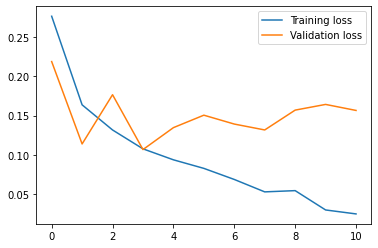

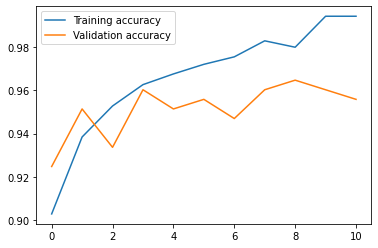

Fold 3 - Numero de epocas realizadas:  11
Entrenando el fold 3 ...
Epoch 1/40
64/64 [==============================] - 19s 294ms/step - loss: 0.2632 - accuracy: 0.9049 - auc: 0.9591 - false_positives: 193.0000 - false_negatives: 193.0000 - true_positives: 1837.0000 - true_negatives: 1837.0000 - val_loss: 0.7049 - val_accuracy: 0.7124 - val_auc: 0.8005 - val_false_positives: 65.0000 - val_false_negatives: 65.0000 - val_true_positives: 161.0000 - val_true_negatives: 161.0000
Epoch 2/40
64/64 [==============================] - 17s 266ms/step - loss: 0.1548 - accuracy: 0.9414 - auc: 0.9820 - false_positives: 119.0000 - false_negatives: 119.0000 - true_positives: 1911.0000 - true_negatives: 1911.0000 - val_loss: 0.2281 - val_accuracy: 0.9159 - val_auc: 0.9613 - val_false_positives: 19.0000 - val_false_negatives: 19.0000 - val_true_positives: 207.0000 - val_true_negatives: 207.0000
Epoch 3/40
64/64 [==============================] - 17s 261ms/step - loss: 0.1281 - accuracy: 0.9571 - auc: 0.9

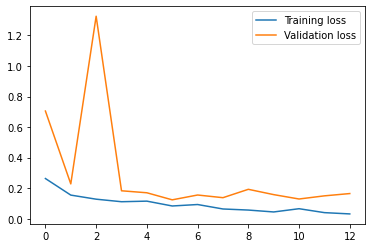

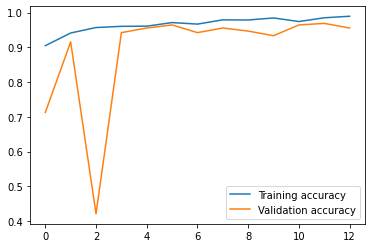

Fold 4 - Numero de epocas realizadas:  13
------------------------------------------------------------------------
Resultados obtenidos:
> Loss function: 0.1151672825217247
> Accuracy: 0.959799329439799
> AUC: 0.9884561896324158
> FP: 45.333333333333336
> FN: 45.333333333333336
> TP: 1082.3333333333333
> TN: 1082.3333333333333


In [ ]:
# Con oversampling
df_vgg=modelo_vgg()

In [ ]:
# Guardamos en disco los resultados
#df_vgg
#df_vgg.to_csv('VGGAumento.csv')

## Modelo 4: 
Añadimos un bloque Inception y a continuación capas Densas junto con capas Dropout y BatchNormalization

In [ ]:
#Función para crear un modulo inception
def inception_module(layer_in, f1, f2_in, f2_out, f3_in, f3_out, f4_out):
	# 1x1 conv
	conv1 = Conv2D(f1, (1,1), padding='same', activation='relu')(layer_in)
	# 3x3 conv
	conv3 = Conv2D(f2_in, (1,1), padding='same', activation='relu')(layer_in)
	conv3 = Conv2D(f2_out, (3,3), padding='same', activation='relu')(conv3)
	# 5x5 conv
	conv5 = Conv2D(f3_in, (1,1), padding='same', activation='relu')(layer_in)
	conv5 = Conv2D(f3_out, (5,5), padding='same', activation='relu')(conv5)
	# 3x3 max pooling
	pool = MaxPooling2D((3,3), strides=(1,1), padding='same')(layer_in)
	pool = Conv2D(f4_out, (1,1), padding='same', activation='relu')(pool)

	layer_out = concatenate([conv1, conv3, conv5, pool], axis=-1)
	return layer_out
 
def modelo_inception():
    
    model = DenseNet121(weights='imagenet', include_top=False,input_shape=(224,224,3))
    model.trainable=False
   
    layer = inception_module(model.output, 64, 96, 128, 16, 32, 32)
   
    layer = inception_module(layer, 128, 128, 192, 32, 96, 64)
    layer = (layers.GlobalAveragePooling2D()) (layer)
    modelSimple= (layers.Dropout(0.4))(layer) 
    modelSimple= (layers.Dense(512, activation = 'relu'))(modelSimple)
    modelSimple= (layers.BatchNormalization())(modelSimple)
    modelSimple= (layers.Dropout(0.5))(modelSimple)
    modelSimple= (layers.Dense(2, activation = 'softmax'))(modelSimple) 
    
    final_model = Model(inputs=model.inputs, outputs=modelSimple)
    
    #model.summary()
    #df=holdout(final_model,training_set,training_labels, model_name='modeloInception',verbose=1, show=True)
    return final_model

Entrenando el fold 1 ...
Epoch 1/40
54/54 [==============================] - 38s 358ms/step - loss: 0.6608 - accuracy: 0.7161 - auc: 0.7954 - false_positives: 490.0000 - false_negatives: 490.0000 - true_positives: 1236.0000 - true_negatives: 1236.0000 - val_loss: 0.1262 - val_accuracy: 0.9635 - val_auc: 0.9966 - val_false_positives: 7.0000 - val_false_negatives: 7.0000 - val_true_positives: 185.0000 - val_true_negatives: 185.0000
Epoch 2/40
54/54 [==============================] - 14s 264ms/step - loss: 0.2730 - accuracy: 0.9305 - auc: 0.9697 - false_positives: 120.0000 - false_negatives: 120.0000 - true_positives: 1606.0000 - true_negatives: 1606.0000 - val_loss: 0.0873 - val_accuracy: 0.9635 - val_auc: 0.9968 - val_false_positives: 7.0000 - val_false_negatives: 7.0000 - val_true_positives: 185.0000 - val_true_negatives: 185.0000
Epoch 3/40
54/54 [==============================] - 14s 264ms/step - loss: 0.1795 - accuracy: 0.9548 - auc: 0.9846 - false_positives: 78.0000 - false_negativ

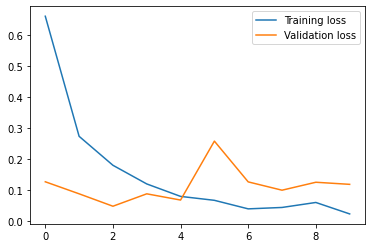

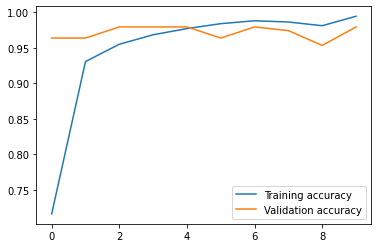

Fold 2 - Numero de epocas realizadas:  10
Entrenando el fold 2 ...
Epoch 1/40
54/54 [==============================] - 17s 309ms/step - loss: 0.6078 - accuracy: 0.7203 - auc: 0.8144 - false_positives: 483.0000 - false_negatives: 483.0000 - true_positives: 1244.0000 - true_negatives: 1244.0000 - val_loss: 0.1899 - val_accuracy: 0.9583 - val_auc: 0.9725 - val_false_positives: 8.0000 - val_false_negatives: 8.0000 - val_true_positives: 184.0000 - val_true_negatives: 184.0000
Epoch 2/40
54/54 [==============================] - 14s 267ms/step - loss: 0.1621 - accuracy: 0.9566 - auc: 0.9812 - false_positives: 75.0000 - false_negatives: 75.0000 - true_positives: 1652.0000 - true_negatives: 1652.0000 - val_loss: 0.1414 - val_accuracy: 0.9688 - val_auc: 0.9776 - val_false_positives: 6.0000 - val_false_negatives: 6.0000 - val_true_positives: 186.0000 - val_true_negatives: 186.0000
Epoch 3/40
54/54 [==============================] - 14s 264ms/step - loss: 0.1056 - accuracy: 0.9728 - auc: 0.9905 - 

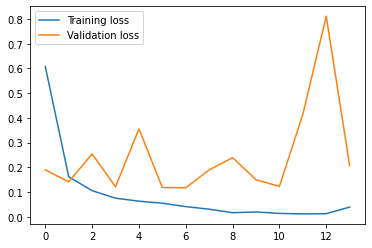

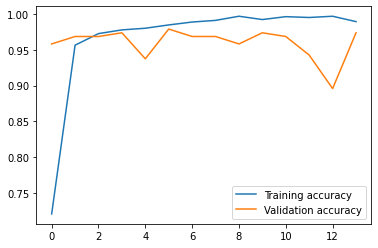

Fold 3 - Numero de epocas realizadas:  14
Entrenando el fold 3 ...
Epoch 1/40
54/54 [==============================] - 15s 278ms/step - loss: 0.5879 - accuracy: 0.7325 - auc: 0.8277 - false_positives: 462.0000 - false_negatives: 462.0000 - true_positives: 1265.0000 - true_negatives: 1265.0000 - val_loss: 0.6572 - val_accuracy: 0.8438 - val_auc: 0.8745 - val_false_positives: 30.0000 - val_false_negatives: 30.0000 - val_true_positives: 162.0000 - val_true_negatives: 162.0000
Epoch 2/40
54/54 [==============================] - 15s 272ms/step - loss: 0.1569 - accuracy: 0.9548 - auc: 0.9888 - false_positives: 78.0000 - false_negatives: 78.0000 - true_positives: 1649.0000 - true_negatives: 1649.0000 - val_loss: 0.1123 - val_accuracy: 0.9635 - val_auc: 0.9861 - val_false_positives: 7.0000 - val_false_negatives: 7.0000 - val_true_positives: 185.0000 - val_true_negatives: 185.0000
Epoch 3/40
54/54 [==============================] - 15s 272ms/step - loss: 0.1200 - accuracy: 0.9629 - auc: 0.9911 

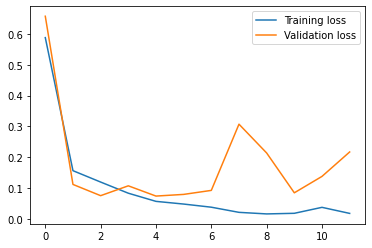

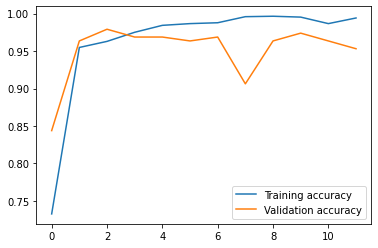

Fold 4 - Numero de epocas realizadas:  12
------------------------------------------------------------------------
Resultados obtenidos:
> Loss function: 0.09652298937241237
> Accuracy: 0.9760257204373678
> AUC: 0.9922368923823038
> FP: 23.0
> FN: 23.0
> TP: 936.3333333333334
> TN: 936.3333333333334


In [ ]:
# Sin oversampling
modelInception = modelo_inception()
df_inception = validacionCruzada(model = modelInception, x_train = training_set, y_train = training_labels, num_folds = 3, model_name='ModeloInception',verbose=1, show=True)

In [ ]:
# Guardamos en disco los resultados
#df_inception.to_csv('InceptionNoAumento.csv')
#df_inception

,ModeloInception
loss,0.096523
accuracy,0.976026
auc,0.992237
precision,0.976025
recall,0.976025
F1-score,0.976025
Gmean,0.976025
FNR,0.023975
FPR,0.023975
TNR,0.976025


29097984/29084464 [==============================] - 0s 0us/step
Entrenando el fold 1 ...
Epoch 1/40
64/64 [==============================] - 335s 5s/step - loss: 0.2880 - accuracy: 0.8926 - auc: 0.9505 - false_positives: 218.0000 - false_negatives: 218.0000 - true_positives: 1811.0000 - true_negatives: 1811.0000 - val_loss: 0.1439 - val_accuracy: 0.9425 - val_auc: 0.9835 - val_false_positives: 13.0000 - val_false_negatives: 13.0000 - val_true_positives: 213.0000 - val_true_negatives: 213.0000
Epoch 2/40
64/64 [==============================] - 325s 5s/step - loss: 0.1799 - accuracy: 0.9340 - auc: 0.9757 - false_positives: 134.0000 - false_negatives: 134.0000 - true_positives: 1895.0000 - true_negatives: 1895.0000 - val_loss: 0.1044 - val_accuracy: 0.9602 - val_auc: 0.9942 - val_false_positives: 9.0000 - val_false_negatives: 9.0000 - val_true_positives: 217.0000 - val_true_negatives: 217.0000
Epoch 3/40
64/64 [==============================] - 328s 5s/step - loss: 0.1441 - accuracy: 0.

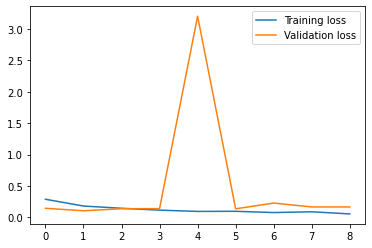

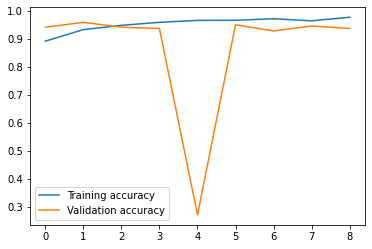

Fold 2 - Numero de epocas realizadas:  9
Entrenando el fold 2 ...
Epoch 1/40
64/64 [==============================] - 325s 5s/step - loss: 0.2963 - accuracy: 0.8935 - auc: 0.9418 - false_positives: 216.0000 - false_negatives: 216.0000 - true_positives: 1813.0000 - true_negatives: 1813.0000 - val_loss: 0.2612 - val_accuracy: 0.9071 - val_auc: 0.9636 - val_false_positives: 21.0000 - val_false_negatives: 21.0000 - val_true_positives: 205.0000 - val_true_negatives: 205.0000
Epoch 2/40
64/64 [==============================] - 336s 5s/step - loss: 0.1851 - accuracy: 0.9295 - auc: 0.9755 - false_positives: 143.0000 - false_negatives: 143.0000 - true_positives: 1886.0000 - true_negatives: 1886.0000 - val_loss: 0.1467 - val_accuracy: 0.9469 - val_auc: 0.9808 - val_false_positives: 12.0000 - val_false_negatives: 12.0000 - val_true_positives: 214.0000 - val_true_negatives: 214.0000
Epoch 3/40
64/64 [==============================] - 337s 5s/step - loss: 0.1476 - accuracy: 0.9487 - auc: 0.9802 - f

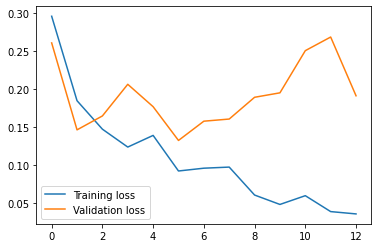

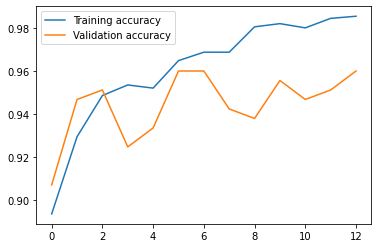

Fold 3 - Numero de epocas realizadas:  13
Entrenando el fold 3 ...
Epoch 1/40
64/64 [==============================] - 338s 5s/step - loss: 0.2998 - accuracy: 0.8887 - auc: 0.9471 - false_positives: 226.0000 - false_negatives: 226.0000 - true_positives: 1804.0000 - true_negatives: 1804.0000 - val_loss: 0.2351 - val_accuracy: 0.9071 - val_auc: 0.9644 - val_false_positives: 21.0000 - val_false_negatives: 21.0000 - val_true_positives: 205.0000 - val_true_negatives: 205.0000
Epoch 2/40
64/64 [==============================] - 337s 5s/step - loss: 0.1772 - accuracy: 0.9360 - auc: 0.9759 - false_positives: 130.0000 - false_negatives: 130.0000 - true_positives: 1900.0000 - true_negatives: 1900.0000 - val_loss: 0.2110 - val_accuracy: 0.9115 - val_auc: 0.9703 - val_false_positives: 20.0000 - val_false_negatives: 20.0000 - val_true_positives: 206.0000 - val_true_negatives: 206.0000
Epoch 3/40
64/64 [==============================] - 336s 5s/step - loss: 0.1371 - accuracy: 0.9458 - auc: 0.9844 - 

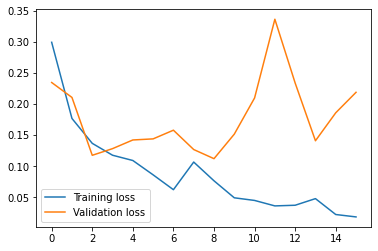

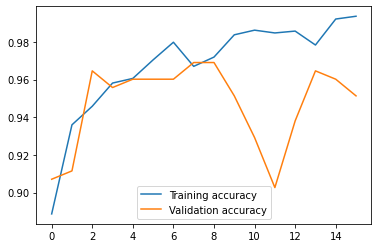

Fold 4 - Numero de epocas realizadas:  16
------------------------------------------------------------------------
Resultados obtenidos:
> Loss function: 0.11925695339838664
> Accuracy: 0.9559582670529684
> AUC: 0.9843078056971232
> FP: 49.666666666666664
> FN: 49.666666666666664
> TP: 1078.0
> TN: 1078.0


In [ ]:
# Con oversampling
df_inception=modelo_inception()

In [ ]:
# Guardamos en disco los resultados
# df_inception.to_csv('InceptionAumento.csv')
# df_inception

# Evaluación en el conjunto de test:

Pasamos a continuación a evaluar dos de los cuatro modelos. Los mejores resultados los presentan los dos primeros modelos. Sin embargo, se va a evaluar un modelo (modelo 2) de los dos más simples (modelos 1 y 2)  y otro (modelo 4) de los dos más complejos (modelos 3 y 4).

In [ ]:
batch_size = 32
epochs = 40
early = 7
opt = tf.keras.optimizers.Adam(learning_rate = 1e-3)

Epoch 1/40
81/81 [==============================] - 48s 358ms/step - loss: 0.4141 - accuracy: 0.8907 - auc: 0.9331 - false_positives: 283.0000 - false_negatives: 283.0000 - true_positives: 2307.0000 - true_negatives: 2307.0000 - val_loss: 0.1681 - val_accuracy: 0.9514 - val_auc: 0.9749 - val_false_positives: 14.0000 - val_false_negatives: 14.0000 - val_true_positives: 274.0000 - val_true_negatives: 274.0000
Epoch 2/40
81/81 [==============================] - 22s 277ms/step - loss: 0.1601 - accuracy: 0.9614 - auc: 0.9863 - false_positives: 100.0000 - false_negatives: 100.0000 - true_positives: 2490.0000 - true_negatives: 2490.0000 - val_loss: 0.1687 - val_accuracy: 0.9583 - val_auc: 0.9849 - val_false_positives: 12.0000 - val_false_negatives: 12.0000 - val_true_positives: 276.0000 - val_true_negatives: 276.0000
Epoch 3/40
81/81 [==============================] - 22s 276ms/step - loss: 0.0843 - accuracy: 0.9784 - auc: 0.9945 - false_positives: 56.0000 - false_negatives: 56.0000 - true_po

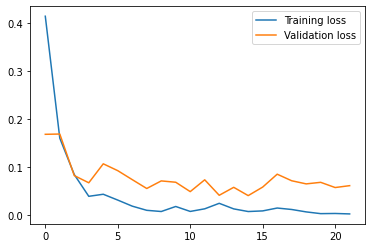

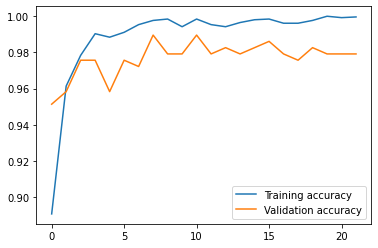

Numero de epocas realizadas:  22
------------------------------------------------------------------------
Resultados obtenidos:
> Loss function: 0.4848082959651947
> Accuracy: 0.9156327247619629
> AUC: 0.9228121042251587
> FP: 34.0
> FN: 34.0
> TP: 369.0
> TN: 369.0


,modelo2 test
loss,0.484808
accuracy,0.915633
auc,0.922812
precision,0.915633
recall,0.915633
F1-score,0.915633
Gmean,0.915633
FNR,0.084367
FPR,0.084367
TNR,0.915633


In [ ]:
# Ejecutamos el modelo
modelo = modelo2()
df_m2_test = fit_evaluate(modelo,'modelo2 test',training_set,training_labels,test_set,test_labels,verbose=1,show = True)

# Guardamos en disco el dataFrame
#df_m2_test.to_csv('Test_m2_binary.csv')

# Imprimimos el dataframe
df_m2_test

Epoch 1/40
81/81 [==============================] - 38s 320ms/step - loss: 0.3614 - accuracy: 0.8444 - auc_1: 0.9289 - false_positives_1: 403.0000 - false_negatives_1: 403.0000 - true_positives_1: 2187.0000 - true_negatives_1: 2187.0000 - val_loss: 0.3162 - val_accuracy: 0.8958 - val_auc_1: 0.9448 - val_false_positives_1: 30.0000 - val_false_negatives_1: 30.0000 - val_true_positives_1: 258.0000 - val_true_negatives_1: 258.0000
Epoch 2/40
81/81 [==============================] - 21s 264ms/step - loss: 0.1108 - accuracy: 0.9625 - auc_1: 0.9902 - false_positives_1: 97.0000 - false_negatives_1: 97.0000 - true_positives_1: 2493.0000 - true_negatives_1: 2493.0000 - val_loss: 0.0922 - val_accuracy: 0.9722 - val_auc_1: 0.9873 - val_false_positives_1: 8.0000 - val_false_negatives_1: 8.0000 - val_true_positives_1: 280.0000 - val_true_negatives_1: 280.0000
Epoch 3/40
81/81 [==============================] - 21s 261ms/step - loss: 0.0806 - accuracy: 0.9726 - auc_1: 0.9934 - false_positives_1: 71.0

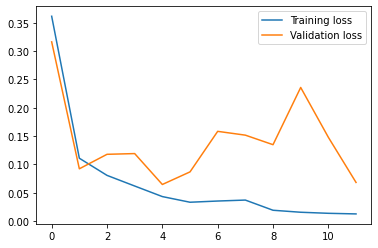

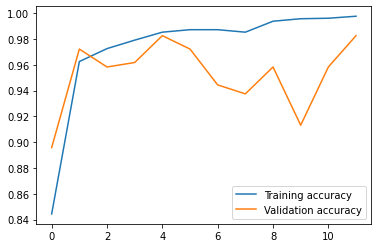

Numero de epocas realizadas:  12
------------------------------------------------------------------------
Resultados obtenidos:
> Loss function: 0.23758578300476074
> Accuracy: 0.9106699824333191
> AUC: 0.9625329375267029
> FP: 36.0
> FN: 36.0
> TP: 367.0
> TN: 367.0


,modelo Inception test
loss,0.237586
accuracy,0.910670
auc,0.962533
precision,0.910670
recall,0.910670
F1-score,0.910670
Gmean,0.910670
FNR,0.089330
FPR,0.089330
TNR,0.910670


In [ ]:
# Ejecutamos el modelo
modelo = modelo_inception()
df_mIcp_test = fit_evaluate(modelo,'modelo Inception test',training_set,training_labels,test_set,test_labels,verbose=1,show = True)

# Guardamos en disco el dataFrame
#df_mIcp_test.to_csv('Test_mIncep_binary.csv')

# Imprimimos el dataframe
df_mIcp_test